This notebook contains material covered in Lectures 2 and 3 of the Introduction to MCMC Methods in Cosmology course. General reference material on MCMC methods is presented in (for example) Hogg and Foreman-Mackey (https://arxiv.org/abs/1710.06068) and was covered in Lecture 1. Coding your own Metropolis/Metropolis-Hastings MCMC sampler was given as a homework problem: to derive maximum benefit from the exercise, you should try doing this yourself (maybe after reading the paper above) before using this notebook. 

To run all cells in this notebook, you will need to have installed the following software packages:
1. emcee (http://dfm.io/emcee/current/)
2. corner.py (https://github.com/dfm/corner.py)
3. GetDist (https://getdist.readthedocs.io/en/latest/)
4. scipy
5. numpy
6. matplotlib

### Import packages and some default plot settings 

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
import time
import random as rd

import corner
import emcee
from getdist import plots, MCSamples
import getdist

rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('axes', linewidth=1.3)
rc('font', **{'weight':'bold'})



# Simple Metropolis MCMC sampler

### 1. Define general functions to calculate the log prior, log likelihood and log posterior. 

The form of these functions is general, but for use in any specific problem you will need to rewrite the likelihood and prior functions accordingly. In particular, for the first examples below I want to sample from specified posteriors, so for now the data vector is not really "data", but simply contains the required mean values of the parameters themselves.

In [2]:
def lnprior(theta):
    """
    Return the log prior for given theta location
    Parameters:
    -----------
    theta:   numpy array
             vector location in parameter space
    """
    
    # default: flat prior on each parameter from -10 to 10
    if np.all(theta > -10) and np.all(theta < 10):
        return 0
    else:
        return -np.inf
    
def lnlike(theta, data, covmat):
    """
    Return the log likelihood for given theta 
    Parameters:
    -----------
    theta:   numpy array, length D
             vector location in parameter space
    data:    numpy array, length N
             the data vector  
    covmat:  numpy array, dimensions NxN
             covariance matrix for data points
    """
    
    # default option: "data" vector actually specifies the mean parameter values (i.e. also N=D here)
    U = np.linalg.inv(covmat)
    chisq = np.dot(np.dot(theta - data, U), theta - data)
    return -0.5 * chisq

def lnprob(theta, data, covmat):
    """
    Return the log posterior for given theta 
    Parameters:
    -----------
    theta:   numpy array
             vector location in parameter space
    data:    numpy array
    covmat:  numpy array
             covariance matrix for data points
    """
    
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    lnlkl = lnlike(theta, data, covmat)
    if not np.isfinite(lnlkl):
        return -np.inf
    return lp + lnlkl


### 2. Gaussian proposal step and the actual sampler

Sampler is simply coded to run for a fixed number of steps specified by the user.

In [3]:
def gaussian_proposal(theta, U, eigv, step_k, update_method='global'):
    """
    Propose step in parameter space starting from given location
    Parameters:
    -----------
    theta:          numpy array
                    vector (length D) with current location in parameter space
    U:              numpy array 
                    DxD tensor of eigenvectors of the inverse of proposal density covariance
    eigv:           numpy array
                    (length D) eigenvalues of the inverse of proposal density covariance
    step_k:         integer
                    step number in the chain (used in sequential updating of parameters)
    update_method:  string, default 'global'
                    sets choice of how to update parameters; 'sequential' performs simplest form of Gibbs sampling
    Returns:
    --------
    new_theta:  numpy array, new location in parameter space
    """
    
    # Initialize random seed
    rd.seed()
    
    # get the jumps in each parameter
    sigmas = np.zeros(len(theta))
    if update_method == 'global':
        # change all parameters together
        for i in range(len(theta)):
            sigmas[i] = np.sqrt(1 / eigv[i] / len(theta)) * rd.gauss(0, 1)
            # note: above line samples from (multivariate) Gaussian proposal density
    elif update_method == 'sequential':
        # change one parameter at a time: simplest Gibbs sampling
        i = step_k % len(theta)
        sigmas[i] = np.sqrt(1 / eigv[i] / len(theta)) * rd.gauss(0, 1)
    else:
        print('Invalid choice of update_method in proposal')
        return
        
    # return the new position in parameter space
    new_theta = theta + np.dot(U, sigmas)
    
    return new_theta

def metropolis_sampler(start_location, psi, data, covmat, K, update_method='global'):
    """
    Run a Markov chain of fixed length using the Metropolis/Metropolis-Hastings MCMC algorithm
    Parameters:
    -----------
    start_location: numpy array
                    parameter vector (length D) specifying starting point for the chain
    psi:            numpy array
                    DxD covariance matrix for proposal density
    data:           numpy array
                    data vector (length N) for use in likelihood function
    covmat:         numpy array
                    NxN covariance matrix for data, for use in likelihood
    K:              integer
                    number of steps to run chain for
    update_method:  string, default 'global'
                    sets choice of how to update parameters
    """
    
    # initialize chain
    chain = np.zeros((K, len(start_location) + 2))
    # set 0th column of chain to 1, as we will repeat samples in the chain but this ensures compatibility with GetDist
    chain[:, 0] = 1
    chain[0, 2:] = start_location
    
    # find starting posterior value 
    logprob = lnprob(start_location, data, covmat) 
    max_logprob = logprob
    
    # chain column 1 stores minus log posterior
    chain[0, 1] = -logprob
    
    # find eigenvalues and eigenvectors of the proposal covariance
    sigma_eigv, U = np.linalg.eig(np.linalg.inv(psi))
    
    # keep track of acceptance fraction
    accepted, rejected = 0.0, 0.0
    
    k = 1
    while k < K:
        new_posn = gaussian_proposal(chain[k-1, 2:], U, sigma_eigv, k, update_method)
        new_logprob = lnprob(new_posn, data, covmat) 
        
        if not np.isfinite(new_logprob):
            # proposed step was bad, so automatically reject
            rejected += 1
            chain[k, :] = chain[k-1, :]
            k += 1
            continue
        
        # otherwise, compare posteriors to decide whether to accept/reject
        if new_logprob >= logprob:
            alpha = 1
        else:
            alpha = np.exp(new_logprob - logprob)
        if (alpha == 1.) or (rd.uniform(0, 1) < alpha):
            # accept the step
            chain[k, 1] = -new_logprob
            chain[k, 2:] = new_posn
            logprob = new_logprob
            accepted += 1
            if logprob > max_logprob:
                max_logprob = logprob
        else:
            # reject the step
            chain[k, :] = chain[k-1, :]  # note that we store both repeated positions in the chain
            rejected += 1
            
        if k % 5000 == 0:
            # output acceptance fraction periodically
            print('Current acceptance fraction, a = %0.2f' %(accepted / (accepted + rejected)))
        
        k += 1
    
    return chain

# Simple tests of MCMC sampling

### 1. Sample from a 1D Gaussian posterior

Mean 2 and variance 2; run for 5000 steps

Current acceptance fraction, a = 0.79


Text(0,0.5,'$p(x)$')

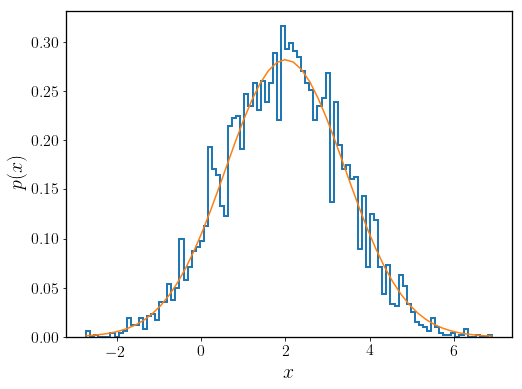

In [4]:
# start from an arbitrary location
start_location = np.array([-1])
# use a proposal width of 1
psi = np.array([[1]])
# specify the posterior to sample from
data = np.array([2])
covmat = np.array([[2]])

chain = metropolis_sampler(start_location, psi, data, covmat, 5001)
# set no. of steps to 5001 just to get the acceptance rate print statement!

# plot a normalised histogram of samples and compare to the true posterior
plt.figure(figsize=(8,6))
_ = plt.hist(chain[:, 2], density=True, histtype='step', bins=100, lw=2, label='sampling')
x = np.linspace(np.min(chain[:, 2]), np.max(chain[:, 2]))
plt.plot(x, np.exp(-(x-2)**2 / 4) / (2*np.sqrt(np.pi)), label='true posterior')
plt.tick_params(labelsize=16)
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$p(x)$', fontsize=20)


View a trace plot of the parameter values in the chain

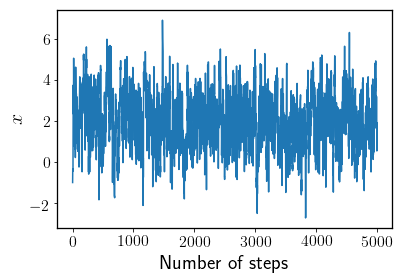

In [5]:
plt.plot(chain[:, 2])
plt.xlabel('Number of steps', fontsize=20)
plt.ylabel('$x$', fontsize=20)
plt.tick_params(labelsize=16)

In [6]:
# save this chain for later use in an example
simple_chain = np.copy(chain)

Questions (try to visualize the answer before executing the code):

1. What happens if you set the starting location to a different value, say -10? What change might you see in the trace plot? What change would you need to make to ensure a good sampling?

2. What happens if you change the proposal width to 0.1? To 100? How does this change the appearance of the trace plot? (For the second case you might need to view only the first few hundred steps of the chain to see it clearly.)

3. Do Problem 9 of https://arxiv.org/abs/1710.06068.

### 2. Sample from a 2D Gaussian posterior

We now have 2 parameters, $x$ and $y$, with a imposed covariance between them. We want to view the 2D distribution as well as the 1D marginalized distributions in $x$ and $y$ – for this we use corner

Current acceptance fraction, a = 0.71
Current acceptance fraction, a = 0.71


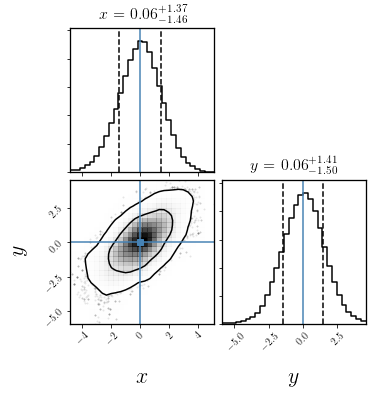

In [7]:
# arbitrary start location
start_location = np.array([3, 3])
# assuming no prior knowledge of the posterior, this is a default proposal
psi = np.array([[1.0, 0], [0, 1.0]])

# data vector and covmat specify the posterior to sample from
data = np.array([0, 0])
covmat = np.array([[2.0, 1.2], [1.2, 2.0]])
    
# we will need to run the chain for longer to get good convergence in 2D
chain = metropolis_sampler(start_location, psi, data, covmat, 10001)

fig = corner.corner(chain[:, [2, 3]], 
                    smooth=1, smooth1d=1, bins=30,
                    labels=[r"$x$", r"$y$"],
                    quantiles=[0.16, 0.84],
                    truths=[0, 0],
                    levels=[0.68, 0.95],
                    show_titles=True, title_kwargs={"fontsize": 16}, 
                    label_kwargs={"fontsize": 22})


Here's how to make the same triangle plot but using GetDist. GetDist can do lots of fun stuff, see https://getdist.readthedocs.io/en/latest/plot_gallery.html for a tutorial notebook. It also has an interactive GUI which is good for analysing cosmological MCMC.

Removed no burn in
x = 0.0\pm 1.4
y = 0.0\pm 1.5


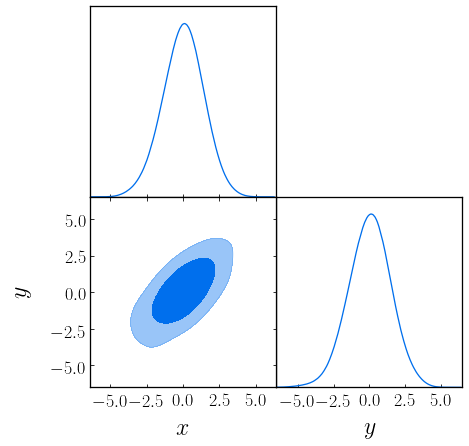

In [9]:
names = ['x', 'y']
labels = ['x', 'y']

samples = MCSamples(samples=chain[:, 2:], names=names, labels=labels, ranges={'x':[-10, 10], 'y':[-10, 10]})

g = plots.getSubplotPlotter(width_inch=6)
g.triangle_plot(samples, filled=True, contour_lws=[1.3])

for i in range(2):
    for ax in g.subplots[i:,i]:
        ax.tick_params(labelsize=18)
        ax.set_ylabel(ax.get_ylabel(), fontsize=24, labelpad=20)
        ax.set_xlabel(ax.get_xlabel(), fontsize=24, labelpad=25)

print(samples.getInlineLatex('x',limit=1))
print(samples.getInlineLatex('y',limit=1))

*[Note that corner and GetDist can sometimes give slightly different estimates of the marginalised uncertainties! I have not investigated this in detail, but it is probably because there are in fact different reasonable choices of how to calculate a 68% C.L. region that need not give the same answer if the posterior is not perfectly Gaussian.]*

Questions:

1. Change the data covariance to make the $x$-$y$ degeneracy much tighter. How does this affect the acceptance rate? Why? What changes might you make to increase the acceptance rate again?

2. Rewrite the prior function to exclude some region of non-zero likelihood, e.g. $x<0$. Re-run the chains and re-plot. What changes do you need to make to the corner plot statement? What changes are needed by GetDist? What goes wrong if you don't make these – especially with GetDist? (**Note**: GetDist uses a Gaussian KDE to estimate the distributions from the samples ...)

3. Do Problems 5 and 6 of https://arxiv.org/abs/1710.06068 

# "Real-world" example: fitting a straight line to noisy data

This example is taken from the emcee demonstration (http://dfm.io/emcee/current/user/line/), but we want to compare different approaches (M-H vs. emcee vs. non-MCMC methods). For a good discussion of fitting a straight line to data, you should read Hogg et al., https://arxiv.org/abs/1008.4686

### 1. Generate some noisy data

The generative model is a straight line but errors in $y$ are underestimated by a constant fractional amount

True parameters: b = 4.294, m = -0.959, f = 0.534 (ln f = -0.627)


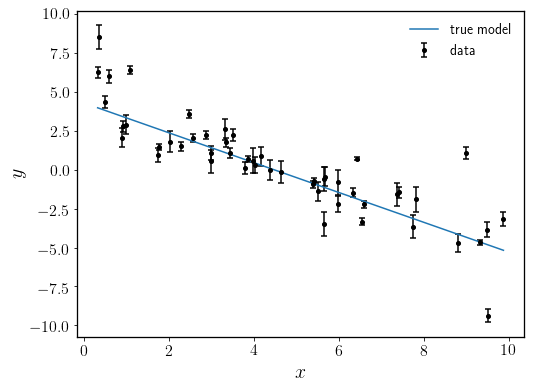

In [10]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
y = m_true * x + b_true

# "known" error
yerr = 0.1 + 0.7*np.random.rand(N)
y += yerr * np.random.randn(N)
# "unknown" error
y += np.abs(f_true * y) * np.random.randn(N)

print('True parameters: b = %0.3f, m = %0.3f, f = %0.3f (ln f = %0.3f)' %(b_true, m_true, f_true, np.log(f_true)))

plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=yerr, c='k', fmt='.', markersize=8, elinewidth=1.5, capsize=3, capthick=1.5, label='data')
plt.plot(x, m_true * x + b_true, label='true model')
plt.tick_params(labelsize=16)
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$y$', fontsize=20)
plt.legend(loc='upper right', numpoints=1, frameon=False, fontsize=14)

### 2. Naive least-squares fit to this data

Let's do a naive least-squares fit first. This *cannot* account for the unknown underestimate of the errors in $y$. It produces some values of $m$ and $b$ but of course no idea of uncertainty in these values. (Note that the actual model fit can sometimes still be quite close to the truth.) 

Least squares fit: b = 4.821, m = -0.935


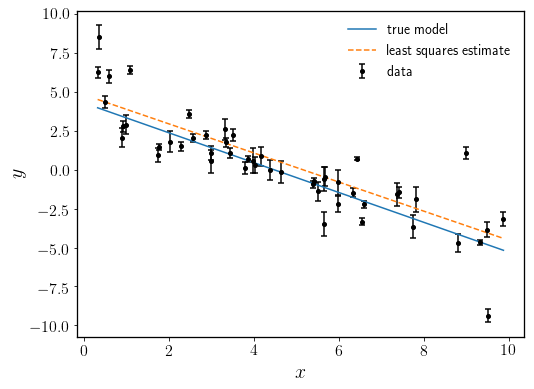

In [11]:
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

print('Least squares fit: b = %0.3f, m = %0.3f' %(b_ls, m_ls))

plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=yerr, c='k', fmt='.', markersize=8, elinewidth=1.5, capsize=3, capthick=1.5, label='data')
plt.plot(x, m_true * x + b_true, label='true model')
plt.plot(x, m_ls * x + b_ls, ls='--', label='least squares estimate')
plt.tick_params(labelsize=16)
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$y$', fontsize=20)
plt.legend(loc='upper right', numpoints=1, frameon=False, fontsize=14)

### 3. A better maximum-likelihood estimation

Define a log-likelihood function, prior and posterior for this specific problem. Note here we use $ln(f)$ instead of $f$ to help with the later sampling. 

In [12]:
def lnlike(theta, data, covmat):
    m, b, lnf = theta
    x = data[0]
    y = data[1]
    yerr = np.sqrt(np.diag(covmat))
    
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    
    return -0.5*(np.sum((y - model)**2 *inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

def lnprob(theta, data, covmat):
    
    x = data[0]
    y = data[1]
    yerr = np.sqrt(np.diag(covmat))
    
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, data, covmat)

Optimise to find maximum likelihood (ML) estimate. This is better than naive least squares (obviously), but still doesn't give uncertainties.

Maximum likelihood optimization: b = 4.550, m = -0.996, f = 0.550 (ln f = -0.597)


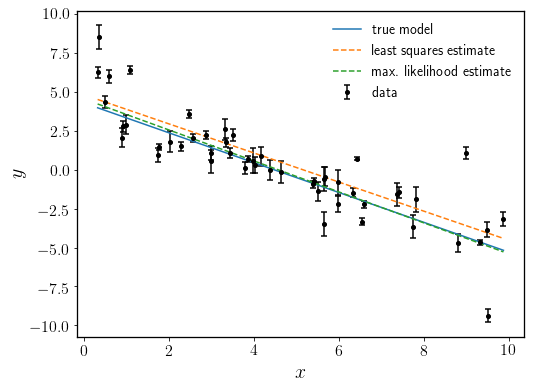

In [13]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)

data = np.vstack([x, y])
covmat = np.diag(yerr * yerr)

result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(data, covmat))
m_ml, b_ml, lnf_ml = result["x"]

print('Maximum likelihood optimization: b = %0.3f, m = %0.3f, f = %0.3f (ln f = %0.3f)' 
      %(b_ml, m_ml, np.exp(lnf_ml), lnf_ml))

plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=yerr, c='k', fmt='.', markersize=8, elinewidth=1.5, capsize=3, capthick=1.5, label='data')
plt.plot(x, m_true * x + b_true, label='true model')
plt.plot(x, m_ls * x + b_ls, ls='--', label='least squares estimate')
plt.plot(x, m_ml * x + b_ml, ls='--', label='max. likelihood estimate')
plt.tick_params(labelsize=16)
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$y$', fontsize=20)
plt.legend(loc='upper right', numpoints=1, frameon=False, fontsize=14)

### 4. Sampling with M-H MCMC (initial)

Try sampling from the posterior using Metropolis-Hastings. Choose the start location at the maximum-likelihood point. We don't know a good proposal matrix yet, so let's start with a diagonal matrix with "guesstimated" step size.

In [14]:
start_location = np.array([m_ml, b_ml, lnf_ml])
psi = np.array([[0.2, 0, 0], [0, 0.2, 0], [0, 0, 0.2]])

start = time.time()
chain = metropolis_sampler(start_location, psi, data, covmat, 10001)
stop = time.time()
print('Time elapsed: %0.2f' %(stop-start))

Current acceptance fraction, a = 0.07
Current acceptance fraction, a = 0.07
Time elapsed: 9.24


Acceptance fraction is very low! Why? What should we conclude?

Check trace plots – these confirm that the chain is not well converged even after 10000 steps.

Text(0.5,0,'Number of steps')

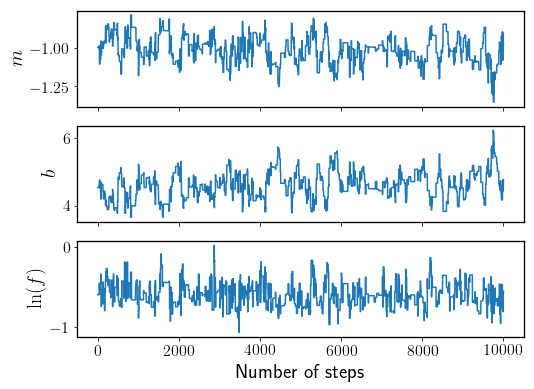

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(8,6), sharex=True)

ax = axes.flat[0]
ax.plot(chain[:, 2])
ax.tick_params(labelsize=16)
ax.set_ylabel('$m$', fontsize=20)
ax = axes.flat[1]
ax.plot(chain[:, 3])
ax.tick_params(labelsize=16)
ax.set_ylabel('$b$', fontsize=20)
ax = axes.flat[2]
ax.plot(chain[:, 4])
ax.tick_params(labelsize=16)
ax.set_ylabel('$\ln(f)$', fontsize=20)
ax.set_xlabel('Number of steps', fontsize=20)


If we make corner plots, the lack of convergence is obvious here too. Can you also see the reason why we did not converge?

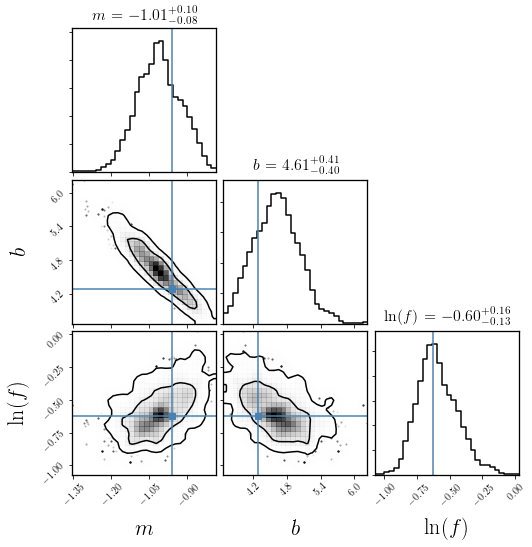

In [16]:
fig = corner.corner(chain[:, 2:], 
                    smooth=1, smooth1d=1, bins=30,
                    labels=[r"$m$", r"$b$", r"$\ln(f)$"],
                    truths=[m_true, b_true, np.log(f_true)],
                    levels=[0.68, 0.95],
                    show_titles=True, title_kwargs={"fontsize": 16}, 
                    label_kwargs={"fontsize": 22})


### 5. Sampling with M-H MCMC (final)

The previous run did not converge because we used a poor proposal. Let's tune the proposal using this information and try again.

In [17]:
# estimate the covariance of the the parameters from the initial chain, use this as the proposal
diffs = chain[:, 2:] - np.mean(chain[:, 2:], axis=0)
psi = np.cov(diffs, rowvar=False)

start = time.time()
chain = metropolis_sampler(start_location, psi, data, covmat, 10001)
stop = time.time()
print('Time elapsed: %0.2f' %(stop-start))

Current acceptance fraction, a = 0.66
Current acceptance fraction, a = 0.66
Time elapsed: 10.20


The acceptance fraction is now much better. This heuristic suggests the chain is probably better converged.

Look at the trace plots: the chain traverses the allowed range of parameter space several times, again suggesting convergence. 
**Note**: For more serious convergence testing, bear in mind:

1. We can (almost) *never* guarantee we have correctly sampled the posterior
2. The error in the sampling is small when the chain length is much longer than the integrated autocorrelation time $\tau_\mathrm{int}$. Estimating $\tau_\mathrm{int}$ is hard, I won't cover it here. But you can estimate the ratio $\tau_\mathrm{int}/N$ "by eye" from the trace plots.
3. A further necessary test of good sampling is to run several chains with different starting positions and check they end up sampling the same posterior mode. I haven't bothered with this here.

Text(0.5,0,'Number of steps')

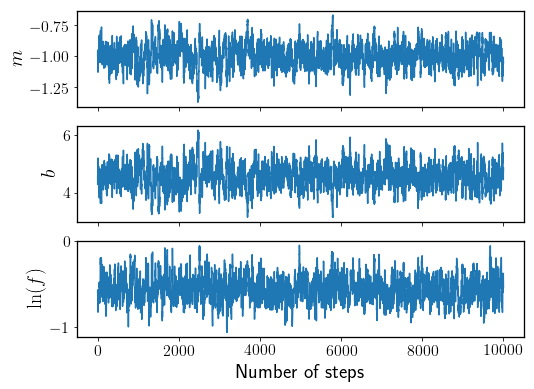

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(8,6), sharex=True)

ax = axes.flat[0]
ax.plot(chain[:, 2])
ax.tick_params(labelsize=16)
ax.set_ylabel('$m$', fontsize=20)
ax = axes.flat[1]
ax.plot(chain[:, 3])
ax.tick_params(labelsize=16)
ax.set_ylabel('$b$', fontsize=20)
ax = axes.flat[2]
ax.plot(chain[:, 4])
ax.tick_params(labelsize=16)
ax.set_ylabel('$\ln(f)$', fontsize=20)
ax.set_xlabel('Number of steps', fontsize=20)


Now look at the corner plots:

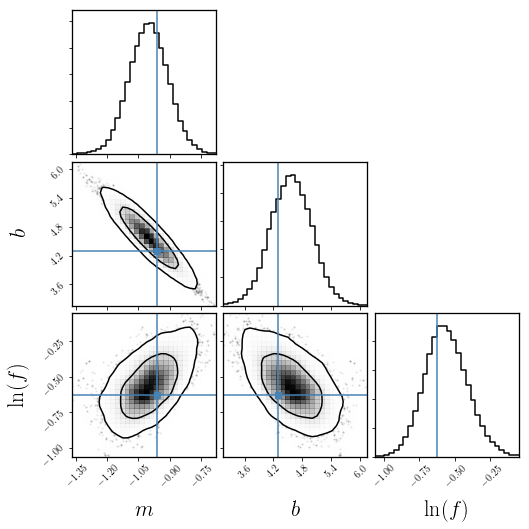

In [19]:
fig = corner.corner(chain[:, 2:], 
                    smooth=1, smooth1d=1, bins=30,
                    labels=[r"$m$", r"$b$", r"$\ln(f)$"],
                    truths=[m_true, b_true, np.log(f_true)],
                    levels=[0.68, 0.95],
                    show_titles=False, title_kwargs={"fontsize": 16}, 
                    label_kwargs={"fontsize": 22})


Quote final results from MCMC analysis (this is one of the reasonable options for doing this):

In [20]:
param_values = chain[:, 2:]
param_values[:, 2] = np.exp(param_values[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(param_values, [16, 50, 84],
                                                axis=0)))
print('Marginalized median results:\n')
print('\tm = %0.2f^{+%0.2f}_{-%0.2f}\n' % m_mcmc)
print('\tb = %0.2f^{+%0.2f}_{-%0.2f}\n' % b_mcmc)
print('\tf = %0.2f^{+%0.2f}_{-%0.2f}\n' % f_mcmc)
print('Compare to truth: m = %0.3f, b = %0.3f, f = %0.3f' % (m_true, b_true, f_true))

Marginalized median results:

	m = -1.00^{+0.09}_{-0.09}

	b = 4.57^{+0.42}_{-0.41}

	f = 0.57^{+0.09}_{-0.07}

Compare to truth: m = -0.959, b = 4.294, f = 0.534


Another good way to visualize the results: posterior predictive plots for models selected randomly from the sampled posterior

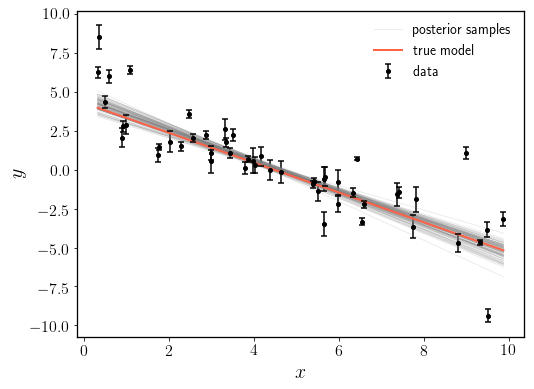

In [21]:
plt.figure(figsize=(8, 6))
first_label = True
for m, b, lnf in chain[np.random.randint(len(chain), size=100), 2:]:
    if first_label:
        plt.plot(x, m*x + b, color="grey", lw=0.7, alpha=0.2, label='posterior samples')
        first_label = False
    else:
        plt.plot(x, m*x + b, color="grey", lw=0.7, alpha=0.2)

plt.plot(x, m_true * x + b_true, lw=2, c='tomato', label='true model')
plt.errorbar(x, y, yerr=yerr, c='k', fmt='.', markersize=8, elinewidth=1.5, capsize=3, capthick=1.5, label='data')
plt.tick_params(labelsize=16)
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$y$', fontsize=20)
plt.legend(loc='upper right', numpoints=1, frameon=False, fontsize=14)


### 5. Sample the same posterior using **emcee**

**emcee** is a Python implementation of an affine-invariant ensemble sampler method. See Foreman-Mackey et al., https://arxiv.org/abs/1202.3665 for the code paper, Goodman & Weare, 2010, Comm. App. Math. Comp. Sci., 5, 65 for the algorithm, http://dfm.io/emcee/current/ for download and usage instructions. 

In [22]:
ndim, nwalkers = 3, 100
# for emcee it is best to start all walkers in a tight ball near the ML point
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(data, covmat))
start = time.time()
sampler.run_mcmc(pos, 2000);
stop = time.time()
print('Time to run = %0.2f seconds' %(stop-start))

Time to run = 10.04 seconds


**Notes**:

1. **emcee** does not require an input proposal matrix. We simply used 100 walkers, and each walker ran for 2000 steps.

2. Overall, this **emcee** run takes almost the same time as the final (tuned) M-H sampling; but it didn't require the intial tuning step. (But also note that this is very simple M-H sampler, which could almost certainly be optimized for speed.)

3. In the end, **emcee** has given us 200,000 samples (vs. 10,000 from final M-H run). These samples are ***not*** from independent chains though!

Check trace plots for a sub-sample of walkers. Taken together the walkers sample the parameter space well, but note that each walker (different colour chains) has a very long autocorrelation time!

Text(0.5,0,'Number of steps')

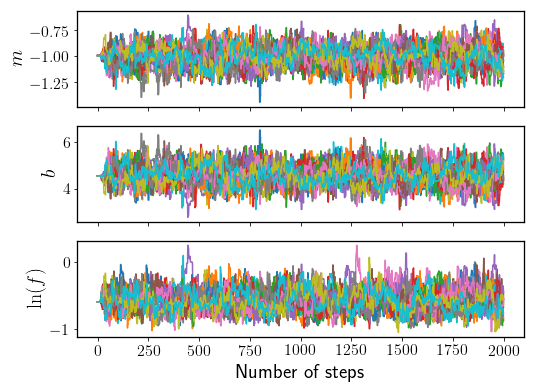

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(8,6), sharex=True)

ax = axes.flat[0]
for i in range(20):
    ax.plot(sampler.chain[i, :, 0])  # note how to access parameter positions in the chain!
ax.tick_params(labelsize=16)
ax.set_ylabel('$m$', fontsize=20)
ax = axes.flat[1]
for i in range(20):
    ax.plot(sampler.chain[i, :, 1])  
ax.tick_params(labelsize=16)
ax.set_ylabel('$b$', fontsize=20)
ax = axes.flat[2]
for i in range(20):
    ax.plot(sampler.chain[i, :, 2])  
ax.tick_params(labelsize=16)
ax.set_ylabel('$\ln(f)$', fontsize=20)
ax.set_xlabel('Number of steps', fontsize=20)



Zoom in on the beginning of the trace plots: notice how the walkers very quickly (within ~50 steps) expand out from the tight initial starting ball to sample the full parameter space. Based on this, a conservative choice of burn-in to discard is maybe 100 steps.

Text(0.5,0,'Number of steps')

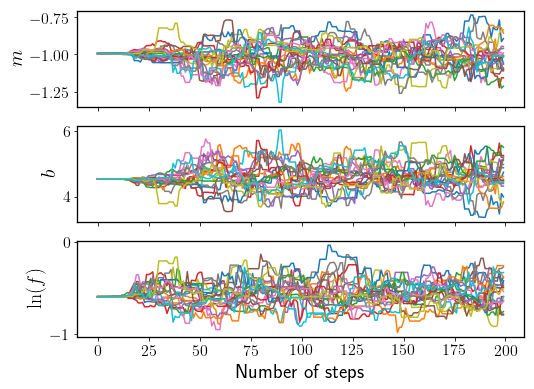

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(8,6), sharex=True)

ax = axes.flat[0]
for i in range(20):
    ax.plot(sampler.chain[i, :200, 0])  # note how to access parameter positions in the chain!
ax.tick_params(labelsize=16)
ax.set_ylabel('$m$', fontsize=20)
ax = axes.flat[1]
for i in range(20):
    ax.plot(sampler.chain[i, :200, 1])  
ax.tick_params(labelsize=16)
ax.set_ylabel('$b$', fontsize=20)
ax = axes.flat[2]
for i in range(20):
    ax.plot(sampler.chain[i, :200, 2])  
ax.tick_params(labelsize=16)
ax.set_ylabel('$\ln(f)$', fontsize=20)
ax.set_xlabel('Number of steps', fontsize=20)



Corner plots from the **emcee** sampling

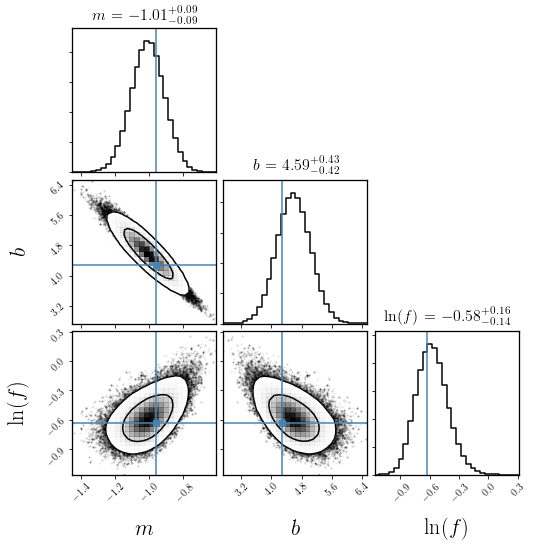

In [25]:
# discard 100 steps of burn-in and join samples from all walkers together
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

fig = corner.corner(samples[:, :], 
                    smooth=1, smooth1d=1, bins=30,
                    labels=[r"$m$", r"$b$", r"$\ln(f)$"],
                    truths=[m_true, b_true, np.log(f_true)],
                    levels=[0.68, 0.95],
                    show_titles=True, title_kwargs={"fontsize": 16}, 
                    label_kwargs={"fontsize": 22})


**emcee** headline results and posterior predictive plots: compare these with those from the M-H sampling above

Marginalized median results:

	m = -1.01^{+0.09}_{-0.09}

	b = 4.59^{+0.43}_{-0.42}

	f = 0.56^{+0.09}_{-0.08}

Compare to truth: m = -0.959, b = 4.294, f = 0.534


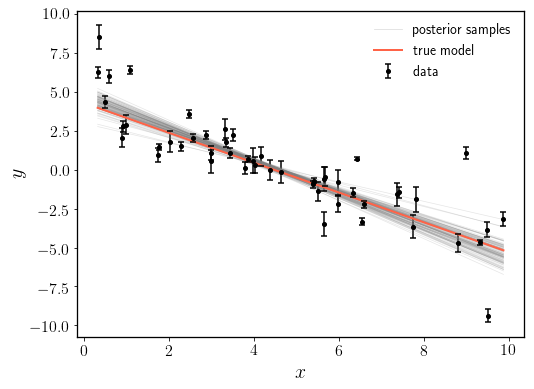

In [26]:
plt.figure(figsize=(8, 6))
first_label = True
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    if first_label:
        plt.plot(x, m*x + b, color="grey", lw=0.7, alpha=0.3, label='posterior samples')
        first_label = False
    else:
        plt.plot(x, m*x + b, color="grey", lw=0.7, alpha=0.2)

plt.plot(x, m_true * x + b_true, lw=2, c='tomato', label='true model')
plt.errorbar(x, y, yerr=yerr, c='k', fmt='.', markersize=8, elinewidth=1.5, capsize=3, capthick=1.5, label='data')
plt.tick_params(labelsize=16)
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$y$', fontsize=20)
plt.legend(loc='upper right', numpoints=1, frameon=False, fontsize=14)

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print('Marginalized median results:\n')
print('\tm = %0.2f^{+%0.2f}_{-%0.2f}\n' % m_mcmc )
print('\tb = %0.2f^{+%0.2f}_{-%0.2f}\n' % b_mcmc)
print('\tf = %0.2f^{+%0.2f}_{-%0.2f}\n' % f_mcmc)
print('Compare to truth: m = %0.3f, b = %0.3f, f = %0.3f' % (m_true, b_true, f_true))

# Other topics covered in these lectures

## A. Advanced methods with M-H MCMC samplers

1. Updating the proposal matrix on-the-fly (implemented in packages like CosmoMC, MontePython)

2. Evaluating convergence on-the-fly and running chains until convergence (implemented in CosmoMC, not in MontePython)

3. Fast-slow decomposition of parameter space for more efficient sampling (https://arxiv.org/abs/1304.4473)

## B. Other sampling methods

**Importance sampling**

Idea: Instead of sampling directly from the "hard" distribution of real interest, sample from an "easy" distribution instead, and then reweight each sample in the chain by 

$w(\theta_k) = \frac{p^\mathrm{hard}(\theta_k)}{p^\mathrm{easy}(\theta_k)}$

where $p(\theta)$ represents the posterior.

Example: take the simple 1D Gaussian sampling from above and reweight the chain to sample from the posterior with the same likelihood but much more complicated (and narrower) prior below. Note that we did not need to re-run the chain!

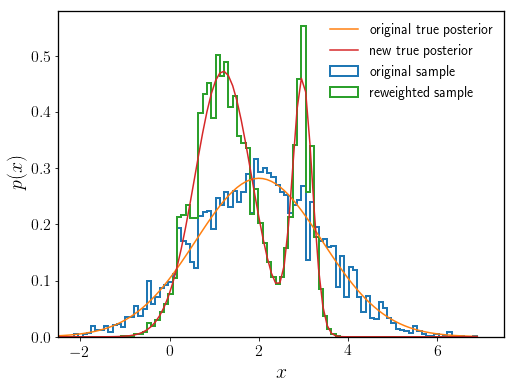

In [27]:
def new_prior(theta):
    
    return np.log(np.exp(-(theta - 1)**2/1) + np.exp(-(theta - 3)**2/0.1))

weights = np.exp(new_prior(simple_chain[:, 2])) 

plt.figure(figsize=(8,6))

# original sampled posterior compared to truth
_ = plt.hist(simple_chain[:, 2], density=True, histtype='step', bins=100, lw=2, label='original sample')
x = np.linspace(np.min(simple_chain[:, 2]), np.max(simple_chain[:, 2]), 101)
plt.plot(x, np.exp(-(x-2)**2 / 4) / (2*np.sqrt(np.pi)), label='original true posterior')

# sampling after reweighting, compared to truth
_ = plt.hist(simple_chain[:, 2], weights=weights, density=True, histtype='step', bins=100, lw=2, 
             label='reweighted sample')
p = np.exp(-(x-2)**2 / 4) * (np.exp(-(x - 1)**2/1) + np.exp(-(x - 3)**2/0.1))
plt.plot(x, p / (1.29796 + 0.433798), label='new true posterior')
# (I used Mathematica to find the correct normalization of the new true posterior!)

plt.ylabel('$p(x)$', fontsize=20)
plt.xlabel('$x$', fontsize=20)
plt.tick_params(labelsize=16)
plt.xlim([-2.5, 7.5])
plt.legend(loc='upper right', numpoints=1, frameon=False, fontsize=14)

And others discussed during the lecture:

1. Gibbs sampling (a trivial form of Gibbs sampling is already implemented in the M-H sampler here, using update_method='sequential')
2. Hamiltonian MC
3. Tempering
4. Nested sampling

## C. Cosmological MCMC packages

Two most well-known are CosmoMC (https://cosmologist.info/cosmomc/readme.html) and Montepython (https://github.com/brinckmann/montepython_public, there is an outdated help page for a previous release available at https://monte-python.readthedocs.io/en/latest/ that is still somewhat useful, a short set of course notes is available at http://www.iac.es/congreso/cosmo2017/media/montepython.pdf). 

To use either of these with Planck CMB data (you almost certainly will want to do this), you also need to download, compile and link the Planck likelihoods. On Sciama this has already been done for you (for the 2015 Planck release), so follow the CosmoMC instructions below (and adapt these similarly for Montepython). There are other packages (e.g. CosmoSIS) that are also supposed to be good, but I've never used them and can't comment.

**Which package should I use?**

- If you need to modify/write your own likelihood functions, I recommend editing **Montepython**. It's written in Python so is much easier to understand and modify; CosmoMC is written in Fortran and is very opaque.

- If you just want to use new data with existing likelihoods, or test different data combinations for an existing model, I recommend using **CosmoMC**. It's relatively easy to just point to new data files, and CosmoMC is in my experience easier to compile on Sciama, faster to converge, more efficient in use of samples, more stable for certain models (especially $w_0-w_a$, $w\Omega_K$CDM etc), and *works with MPI* (in practice on Sciama Montepython does not!)

- For plotting/analyzing chains obtained from *either* package, I **strongly recommend** using **GetDist** (which is bundled with CosmoMC but you've probably also already downloaded it). Montepython's plotting scripts are ugly, hard to customise, and in some cases possibly inaccurate.

- If you actually want to modify the underlying Boltzmann code or some other aspect of the physics (e.g. the primordial power spectrum from inflationary models), I'd say (a) don't, (b) if you have to, maybe best use Montepython and try modifying CLASS, and (c) good luck. [I spent 3 years of my PhD wrestling with CosmoMC and CAMB in Fortran :( – but having said that, apparently newer releases of CAMB have Python implementations, so maybe try that ... ]

### How to run CosmoMC on Sciama

(Note: these notes based on how things worked on the old Sciama: some things may have changed after the upgrade. Notes compiled together with Hans Winther.)

1] Import the following modules and the Planck likelihood plc
    module purge
    export MODULEPATH=$NEW_MODULEPATH
    module load system
    module load intel_comp/2016.2
    module load openmpi/2.0.2
    module load plc/2.0

2] Add [CLIK_PATH = /opt/apps/clik/2.0/intel64/intel_2016.2/] to the top of CosmoMC/source/Makefile

3] Compile CosmoMC [ make ]

4] *Optional*: Compile getdist [ make getdist ]

5] Edit the file CosmoMC/test.ini to set analysis options and choose which datasets to fit

    - data files are separated into different batch folders (batch1/, batch2/ and batch3/ roughly representing the state of cosmology data at the time of the 1st, 2nd and 3rd Planck data releases)
    
    - for instance, uncommenting the line DEFAULT(batch3/BAO.ini) in CosmoMC/test.ini will include fits to the most up-to-date BAO results used by Planck 2018; inserting DEFAULT(batch3/BAO_RSD.ini) instead will include BAO+RSD results, DEFAULT(batch3/JLA.ini) will add JLA supernova results etc.
    
    - view the file in question (e.g. batch3/BAO.ini) to see which results are included (in this case, BOSS DR12 BAO consensus, 6dF and SDSS MGS) and edit as required [Note: .ini files frequently point to other .ini files in a heirarchy!]
    
    - if you want to add fits to some new data replacing/updating existing data (e.g., a re-analysis of BOSS DR12 BAO) then examine the heirarchy of .ini files to find the final .dataset file they point to (will be in the folder CosmoMC/data/), and edit that (or, better, edit a copy of it and change the path the .ini files point to)
    
    - in each batchX/ folder, there are files called common.ini and params_CMB_default.ini. If you want to add any parameters to the model (e.g. neutrino mass) or to change any settings for the run (e.g., convergence criterion, sampling method, etc.), either edit relevant lines here or (better) add the relevant lines to the test.ini file where they will override

6] Create a directory to store the output of your run, cd to this directory

7] Submit the following job to the Sciama queue:
   
   mpirun -np 8 \$cosmomc \$paramfile
   
   where cosmomc="/path/to/the/cosmomc/executable/from/step/3/", and paramfile="/path/to/the/highest/level/ini/file/"
   
   Option -np 8 will automatically start 8 chains from different initial points, and will assess their convergence on-the-fly, stopping once they reach the desired convergence criterion (by default, Gelman-Rubin criterion R < 0.05)
   
8] When your chains have finished, analyse the folder using GetDist

9] Publish!

# Reading / further material

In addition to the papers and websites highlighted above, you can also have a look at:

1. https://m-clark.github.io/docs/ld_mcmc/: A list of MCMC algorithms, with a short description and summary of each, plus references to the literature

2. https://gabriel-p.github.io/pythonMCMC/: A list of public Python-based MCMC packages. One of these might be useful if you need something more powerful than your home-made M-H sampler!

3. CosmoHammer, Akeret et al, https://arxiv.org/abs/1212.1721: an implementation of emcee for cosmological analysis (i.e. fitting CMB data), that scales to use thousands of cores